In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

ModuleNotFoundError: No module named 'cv2'

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable save memoria
    results = model.process(image)                 # Make prediction ได้ landmark
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def draw_landmarks(image, results):
   #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    '''mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              ) '''
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
     #Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
cap = cv2.VideoCapture(0)
#Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
draw_landmarks(frame, results)

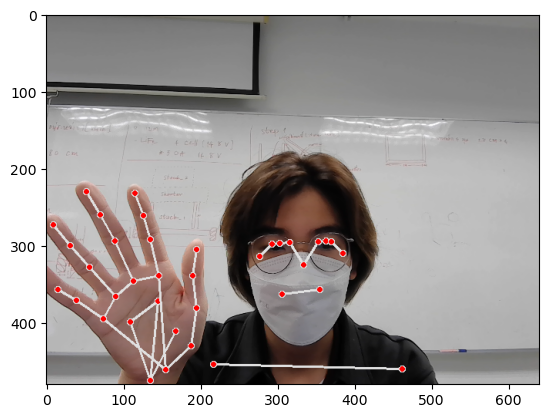

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Extract Keypoint

In [ ]:
'''pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
#face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)'''

In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)##
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

## Setup Folder for array collection

In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data(10)') 

# Actions that we try to detect
actions = np.array(['come', 'done', 'eat', 'hello', 'iloveyou', 'no', 'ok', 'please', 'thanks', 'yes'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [ ]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Collecting Keypoint

In [ ]:
'''cap = cv2.VideoCapture(0)
 # Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
     # NEW LOOP
     # Loop through actions
     for action in actions:
         # Loop through sequences aka videos
         for sequence in range(no_sequences):
             # Loop through video length aka sequence length
             for frame_num in range(sequence_length):

                 # Read feed
                 ret, frame = cap.read()

                 # Make detections
                 image, results = mediapipe_detection(frame, holistic)
#                print(results)

                 # Draw landmarks
                 draw_styled_landmarks(image, results)
                
                 # NEW Apply wait logic
                 if frame_num == 0: 
                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                     # Show to screen
                     cv2.imshow('OpenCV Feed', image)
                     cv2.waitKey(500)
                 else: 
                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                     cv2.imshow('OpenCV Feed', image)
                
                 # NEW Export keypoints
                 keypoints = extract_keypoints(results)
                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                 np.save(npy_path, keypoints)

                 # Break gracefully
                 if cv2.waitKey(10) & 0xFF == ord('q'):
                     break
                    
     cap.release()
     cv2.destroyAllWindows()'''

: 

: 

## Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

{'come': 0,
 'done': 1,
 'eat': 2,
 'hello': 3,
 'iloveyou': 4,
 'no': 5,
 'ok': 6,
 'please': 7,
 'thanks': 8,
 'yes': 9}

In [ ]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05) #test เยอะๆ แล้ว train นิดๆ 95%

## Build LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, activation='sigmoid', input_shape=(30,258)))
model.add(LSTM(512, return_sequences=True, activation='sigmoid'))
model.add(LSTM(256, return_sequences=False, activation='sigmoid'))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
res = [0.3, 0.7, 0.1]

In [ ]:
actions[np.argmax(res)]

'done'

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback]) #fit คือ tarin

Epoch 1/1000
9/9 [==============================] - 4s 241ms/step - loss: 2.6671 - categorical_accuracy: 0.0982
Epoch 2/1000
9/9 [==============================] - 2s 251ms/step - loss: 2.4444 - categorical_accuracy: 0.1088
Epoch 3/1000
9/9 [==============================] - 2s 250ms/step - loss: 2.4011 - categorical_accuracy: 0.0842
Epoch 4/1000
9/9 [==============================] - 2s 256ms/step - loss: 2.4081 - categorical_accuracy: 0.0737
Epoch 5/1000
9/9 [==============================] - 2s 269ms/step - loss: 2.3681 - categorical_accuracy: 0.1123
Epoch 6/1000
9/9 [==============================] - 2s 265ms/step - loss: 2.3762 - categorical_accuracy: 0.0807
Epoch 7/1000
9/9 [==============================] - 3s 278ms/step - loss: 2.3645 - categorical_accuracy: 0.0877
Epoch 8/1000
9/9 [==============================] - 2s 276ms/step - loss: 2.3669 - categorical_accuracy: 0.0947
Epoch 9/1000
9/9 [==============================] - 3s 283ms/step - loss: 2.3611 - categorical_accuracy:

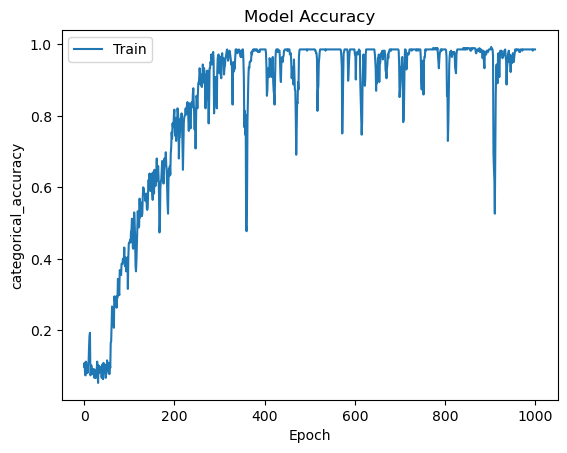

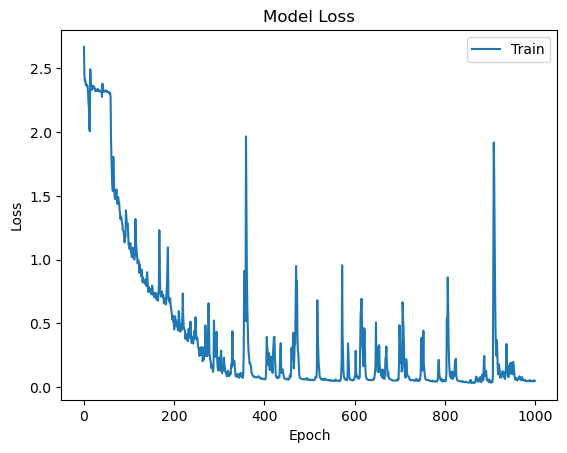

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


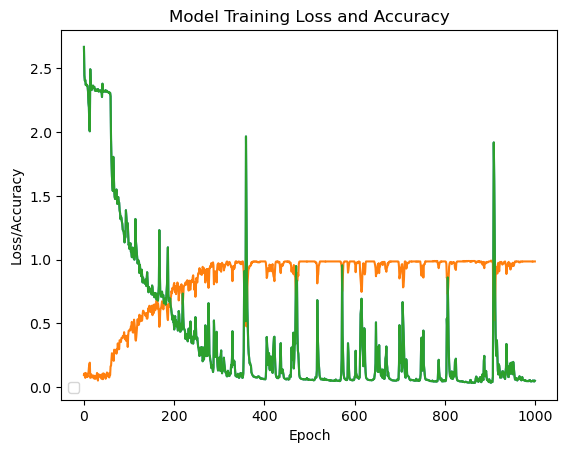

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Training Loss and Accuracy')
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['loss'])
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower left")
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           527360    
                                                                 
 lstm_1 (LSTM)               (None, 30, 512)           1574912   
                                                                 
 lstm_2 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 3,682,826
Trainable params: 3,682,826
Non-

## Make Prediction

In [ ]:
res = model.predict(X_test)

1/1 [==============================] - 0s 295ms/step


In [ ]:
actions[np.argmax(res[4])]

'please'

In [ ]:
actions[np.argmax(y_test[4])]

'please'

## Save Weight

In [ ]:
model.save('action.h5')

In [ ]:
#del model

In [ ]:
model.load_weights('action.h5')

## Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 40ms/step


In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[14,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  2]],

       [[14,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  2]],

       [[13,  0],
        [ 0,  2]],

       [[13,  0],
        [ 0,  2]],

       [[14,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  2]],

       [[13,  0],
        [ 0,  2]]], dtype=int64)

In [ ]:
accuracy_score(ytrue, yhat)

1.0

## Test in Real Time

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        #draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            try:
                image = prob_viz(res, actions, image, colors)
            except:
                pass
                
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti